In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image


In [2]:
# Prepare torchvision MNIST datasets and loaders
print("Preparing MNIST datasets (torchvision)...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),            # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST normalization
])

train_dataset = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

input_dim = 28 * 28
num_classes = 10

print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Preparing MNIST datasets (torchvision)...
Device: cpu
Train batches: 235, Test batches: 40


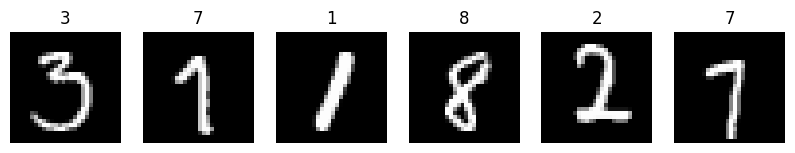

In [3]:
# Preview a few images from the DataLoader
np.set_printoptions(linewidth=200, threshold=784, suppress=True)

examples, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(examples[i, 0].numpy(), cmap='gray')
    axes[i].set_title(int(labels[i]))
    axes[i].axis('off')
plt.show()

In [4]:
# Define a logistic-regression-like network: input -> output (no hidden layers)
class MNISTLinear(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTLinear(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


MNISTLinear(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [5]:
# Train and evaluate
num_epochs = 5  # liczba epok treningu
log_interval = 100  # co ile batchy logować średnią stratę

train_losses = []  # historia strat treningowych (tu nie jest wypełniana)
train_accuracies = []  # historia dokładności treningowych w %
test_accuracies = []  # historia dokładności testowych w %

for epoch in range(1, num_epochs + 1):  # pętla po epokach
    model.train()  # przełącz model w tryb treningu
    correct = 0  # licznik trafnych przewidywań (train)
    total = 0  # licznik wszystkich przykładów (train)
    running_loss = 0.0  # akumulacja straty do logowania

    for batch_idx, (inputs, targets) in enumerate(train_loader, start=1):  # pętla po batchach treningowych
        inputs = inputs.to(device)  # przenieś obrazy na CPU/GPU
        targets = targets.to(device)  # przenieś etykiety na CPU/GPU

        optimizer.zero_grad()  # wyzeruj zebrane gradienty
        outputs = model(inputs)  # przód: oblicz logity dla batcha
        loss = criterion(outputs, targets)  # policz stratę (np. CrossEntropyLoss)
        loss.backward()  # wstecz: policz gradienty
        optimizer.step()  # zaktualizuj wagi modelu

        running_loss += loss.item()  # dodaj bieżącą stratę do sumy
        _, predicted = outputs.max(1)  # argmax po klasach = przewidziana klasa
        total += targets.size(0)  # zwiększ licznik przykładów
        correct += predicted.eq(targets).sum().item()  # zwiększ licznik trafień

        if batch_idx % log_interval == 0:  # co N batchy wypisz średnią stratę
            print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {running_loss/log_interval:.4f}")  # log
            running_loss = 0.0  # reset akumulatora straty

    train_acc = 100.0 * correct / total  # dokładność treningowa w %
    train_accuracies.append(train_acc)  # zapisz dokładność do historii
    print(f"Epoch {epoch} training accuracy: {train_acc:.2f}%")  # wypisz wynik treningu


    model.eval()  # przełącz model w tryb ewaluacji
    correct = 0  # reset trafień (test)
    total = 0  # reset liczby przykładów (test)
    with torch.no_grad():  # bez śledzenia gradientów (szybciej, oszczędniej)
        for inputs, targets in test_loader:  # pętla po batchach testowych
            inputs = inputs.to(device)  # przenieś obrazy na CPU/GPU
            targets = targets.to(device)  # przenieś etykiety na CPU/GPU
            outputs = model(inputs)  # przewidywania dla testu
            _, predicted = outputs.max(1)  # klasa o najwyższym wyniku
            total += targets.size(0)  # zwiększ licznik przykładów (test)
            correct += predicted.eq(targets).sum().item()  # zwiększ trafienia (test)
    test_acc = 100.0 * correct / total  # dokładność testowa w %
    test_accuracies.append(test_acc)  # zapisz do historii
    print(f"Epoch {epoch} test accuracy: {test_acc:.2f}%")  # wypisz wynik testu


Epoch 1 [100/235] Loss: 0.7550
Epoch 1 [200/235] Loss: 0.3815
Epoch 1 training accuracy: 84.95%
Epoch 1 test accuracy: 91.00%
Epoch 2 [100/235] Loss: 0.3254
Epoch 2 [200/235] Loss: 0.3115
Epoch 2 training accuracy: 91.00%
Epoch 2 test accuracy: 91.68%
Epoch 3 [100/235] Loss: 0.3033
Epoch 3 [200/235] Loss: 0.2865
Epoch 3 training accuracy: 91.68%
Epoch 3 test accuracy: 92.29%
Epoch 4 [100/235] Loss: 0.2783
Epoch 4 [200/235] Loss: 0.2915
Epoch 4 training accuracy: 91.98%
Epoch 4 test accuracy: 91.99%
Epoch 5 [100/235] Loss: 0.2689
Epoch 5 [200/235] Loss: 0.2791
Epoch 5 training accuracy: 92.32%
Epoch 5 test accuracy: 91.97%


In [6]:
# Save model and export ONNX
os.makedirs("outputs", exist_ok=True)

pth_path = os.path.join("outputs", "mnist_mlp.pth")
torch.save(model.state_dict(), pth_path)
print(f"Saved weights to {pth_path}")

# Export to ONNX
onnx_path = os.path.join("outputs", "mnist_mlp.onnx")
model_cpu = model.to("cpu").eval()
dummy = torch.randn(1, 1, 28, 28)
torch.onnx.export(
    model_cpu,
    dummy,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=13
)
print(f"Exported ONNX to {onnx_path}")


Saved weights to outputs\mnist_mlp.pth
Exported ONNX to outputs\mnist_mlp.onnx


C:\Users\micha\AppData\Local\Temp\ipykernel_18872\2337890801.py:12: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


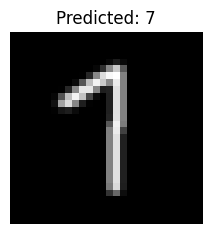

7


In [9]:
# Predict digit from test2.png, display centered 20x20 on 28x28 and print predicted digit
img_path = "test2.png"
model_path = os.path.join("outputs", "mnist_mlp.pth")  # reuse existing weights filename

# Fallback: define MNISTLinear if not present (matches current definition)
try:
    MNISTLinear
except NameError:
    class MNISTLinear(nn.Module):
        def __init__(self, input_dim: int, num_classes: int):
            super().__init__()
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_dim, num_classes)
            )
        def forward(self, x):
            return self.net(x)

if not os.path.exists(img_path):
    raise FileNotFoundError("test2.png not found")

# Load, convert to grayscale, resize to 20x20
img_orig = Image.open(img_path).convert("L")
img_20 = img_orig.resize((20, 20), resample=Image.BILINEAR)

# Create 28x28 black canvas and center the 20x20 digit
canvas = Image.new("L", (28, 28), color=0)  # black background like MNIST
offset = ((28 - 20) // 2, (28 - 20) // 2)  # (4, 4)
canvas.paste(img_20, offset)

# Show processed image
plt.figure(figsize=(2.5, 2.5))
plt.imshow(canvas, cmap='gray')
plt.axis('off')

# Preprocess for model
to_tensor = transforms.ToTensor()
tensor = to_tensor(canvas)  # -> [0,1], (1,28,28)
# Auto-invert if background looks white
if tensor.mean().item() > 0.5:
    tensor = 1.0 - tensor
normalize = transforms.Normalize((0.1307,), (0.3081,))
tensor = normalize(tensor).unsqueeze(0)  # (1,1,28,28)

# Load model and predict
if not os.path.exists(model_path):
    raise FileNotFoundError("Model weights not found. Train and save first.")
model_cpu = MNISTLinear(input_dim=28*28, num_classes=10)
state = torch.load(model_path, map_location="cpu")
model_cpu.load_state_dict(state)
model_cpu.eval()
with torch.no_grad():
    logits = model_cpu(tensor)
    pred = int(logits.argmax(dim=1).item())

# Print prediction under the image
plt.title(f"Predicted: {pred}")
plt.show()
print(pred)
